In [1]:
%load_ext autoreload
%autoreload 2
import sys
from numba import njit
from glob import glob
from natsort import natsorted
from joblib import Parallel, delayed
sys.path.insert(0, "../../") 
import tifffile
from helpers import *
import nd2
from PIL import Image
import global_params
from tqdm.auto import tqdm
from skimage.segmentation import clear_border
sys.path.insert(0, "/home/gh464/Documents/GitHub/SyMBac/") 
from SyMBac.drawing import  get_crop_bounds_2D
from skimage.restoration import rolling_ball


In [6]:
data = pd.read_pickle("agar_pad.pickle")
data["Distance from centre of colony"] = np.sqrt(
    (data["Cell y"] - data["Colony centroid y"])**2 + (data["Cell x"] - data["Colony centroid x"])**2 
)
data["Normalised distance from centre of colony"] = data["Distance from centre of colony"] / (data["Colony diameter"]/2)
data["Mean true intensity"] = data["True intensity"] / data["Area"]

#data = data[~(data["Mean true intensity"] > 0)]

In [7]:
data = data.query("`True intensity` != 0")

In [8]:
data["file"].unique()

array(['100x_SB5_dilute002_segmented', '100x_SB6_dilute002_segmented',
       '40x_SB6_dilute001_segmented', '40x_SB5_dilute001_segmented'],
      dtype=object)

In [9]:
data = data.query("Area < 4000")

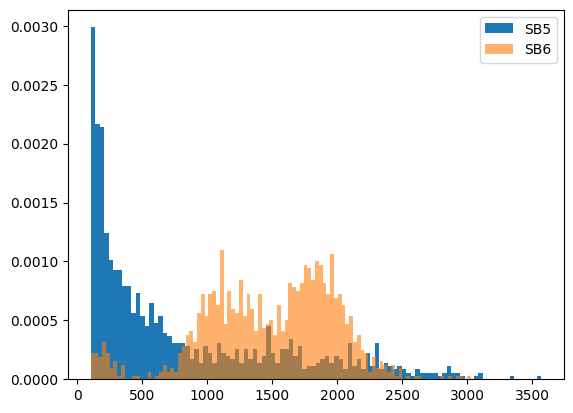

In [60]:
plt.hist(
    data.query("`file` == '100x_SB5_dilute002_segmented' & `Colony N cells` == 1  ")["Area"], bins = 100,  density = True
)
plt.hist(
    data.query("`file` == '100x_SB6_dilute002_segmented' & `Colony N cells` == 1 ")["Area"], bins = 100, density = True, alpha = 0.6,
)
plt.legend(["SB5", "SB6"])
plt.show()

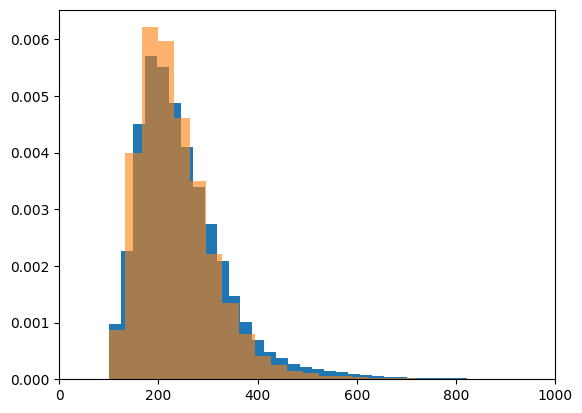

In [32]:
plt.hist(
    data.query("`file` == '40x_SB5_dilute001_segmented'")["Area"], bins = 100,  density = True
)
plt.hist(
    data.query("`file` == '40x_SB6_dilute001_segmented'")["Area"], bins = 100, density = True, alpha = 0.6,
)
plt.legend(["SB5", "SB6"])
plt.xlim(0,1000)
plt.show()

In [56]:
import ipywidgets as widgets
from ipywidgets import HBox, VBox
@widgets.interact(
    max_cells=(1,400))
def plot(max_cells=1):
    
    plt.hist(
        data.query("`file` == '40x_SB5_dilute001_segmented' & `Colony N cells` > @max_cells")["Mean true intensity"], bins = 50, density = True, alpha=0.6
    )
    
    plt.hist(
        data.query("`file` == '40x_SB6_dilute001_segmented' & `Colony N cells` > @max_cells")["Mean true intensity"], bins = 50, density = True, alpha=0.6
    )
    plt.legend(["SB5", "SB6"])
    plt.show()
    plt.close()

interactive(children=(IntSlider(value=1, description='max_cells', max=400, min=1), Output()), _dom_classes=('w…

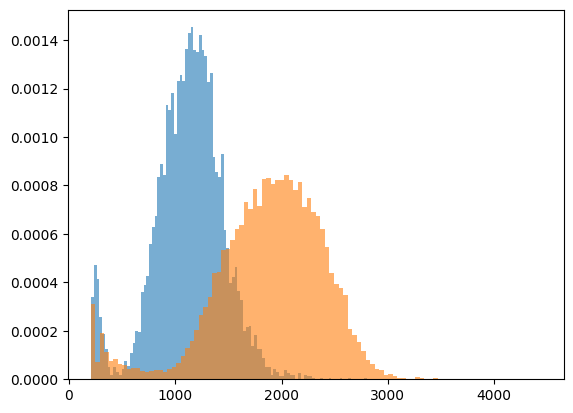

In [39]:
plt.hist(
    data.query("`file` == '40x_SB6_dilute001_segmented' & `Colony N cells` == 1")["Mean true intensity"], bins = 100, density = True, alpha = 0.6,
)

plt.hist(
    data.query("`file` == '40x_SB6_dilute001_segmented' & `Colony N cells` > 50")["Mean true intensity"], bins = 100, density = True, alpha = 0.6,
)

plt.show()

<AxesSubplot:>

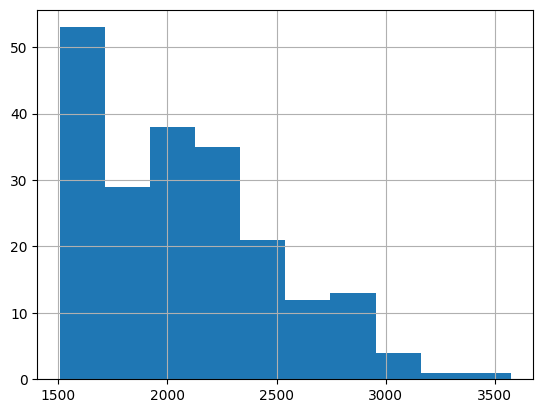

In [25]:
sb6_100x_intensity = data.query("`file` == '100x_SB5_dilute002_segmented' & `Colony N cells` == 1 & 1500 < `Area` < 5000")
sb6_100x_intensity["Area"].hist()

In [26]:
sb6_100x_intensity.std()/sb6_100x_intensity.mean()

/tmp/ipykernel_26481/178506616.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  sb6_100x_intensity.std()/sb6_100x_intensity.mean()


Label                                        1.971647
True intensity                               0.688445
Observed intensity                           0.688445
Colony circularity                           0.121303
Cell y                                       0.679701
Cell x                                       0.604859
Colony diameter                              0.176345
Colony centroid y                            0.679701
Colony centroid x                            0.604859
N neighbours                                      NaN
Colony N cells                               0.000000
Area                                         0.202139
Distance from centre of colony                    NaN
Normalised distance from centre of colony         NaN
Mean true intensity                          0.679911
dtype: float64